<a href="https://colab.research.google.com/github/nguyenngoctham02da/Reviews-Classification-using-Naive-Bayes-XGBoost-and-LSTM/blob/main/Reviews_Classification_using_Naive_Bayes%2C_XGBoost_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I have a dataset of product information, ratings, and customer reviews for those products.

I have to find out:
- Number of ratings and sentiment
- Is the longer a review a negative review?
- Popular keywords in each type of review

I have to build a text classification model. I used 3 models and found the one with the highest accuracy.

In [1]:
import pandas as pd

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import numpy as np
import re
import plotly.express as px
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras.layers import GlobalAvgPool1D
import tensorflow as tf

# Data mining

In [3]:
df1=pd.read_csv('/content/drive/MyDrive/DatasetDA/NLP/Dataset-SA.csv')
df1

product_name product_price Rate  \
0       Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    5   
1       Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    5   
2       Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    3   
3       Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    1   
4       Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    3   
...                                                   ...           ...  ...   
205047  cello Pack of 18 Opalware Cello Dazzle Lush Fi...          1299    5   
205048  cello Pack of 18 Opalware Cello Dazzle Lush Fi...          1299    5   
205049  cello Pack of 18 Opalware Cello Dazzle Lush Fi...          1299    3   
205050  cello Pack of 18 Opalware Cello Dazzle Lush Fi...          1299    5   
205051  cello Pack of 18 Opalware Cello Dazzle Lush Fi...          1299    4   

                 Review                                            Summary  \
0                super!  great cooler excellent air flow and for this p...   
1               awesome              best budget 2 fit cooler nice cooling   
2                  fair  the quality is good but the power of air is de...   
3       useless product                  very bad product its a only a fan   
4                  fair                                      ok ok product   
...                 ...                                                ...   
205047        must buy!                                       good product   
205048           super!                                               nice   
205049             nice                        very nice and fast delivery   
205050        just wow!                                    awesome product   
205051  value-for-money  very good but mixing bowl not included is one ...   

       Sentiment  
0       positive  
1       positive  
2       positive  
3       negative  
4        neutral  
...          ...  
205047  positive  
205048  positive  
205049  positive  
205050  positive  
205051   neutral  

[205052 rows x 6 columns]

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205052 entries, 0 to 205051
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   product_name   205052 non-null  object
 1   product_price  205052 non-null  object
 2   Rate           205052 non-null  object
 3   Review         180388 non-null  object
 4   Summary        205041 non-null  object
 5   Sentiment      205052 non-null  object
dtypes: object(6)
memory usage: 9.4+ MB


In [5]:
df1.isnull().sum()

product_name         0
product_price        0
Rate                 0
Review           24664
Summary             11
Sentiment            0
dtype: int64

In [6]:
df1.shape

(205052, 6)

# Pre-processing

1. Drop null value of summary column
2. Convert the data type of rate and price column to numeric form
3. Find and remove outliers and anomalies
4. Create more useful columns: convert sentiment to numeric form, create additional columns length_of_text

In [7]:
df1.dropna(subset=['Summary'], inplace=True)

In [8]:
df1.isnull().sum()

product_name         0
product_price        0
Rate                 0
Review           24662
Summary              0
Sentiment            0
dtype: int64

In [9]:
df1['Rate'].value_counts()

5                                                                    118758
4                                                                     41891
1                                                                     21300
3                                                                     16599
2                                                                      6490
Pigeon Favourite Electric Kettle??????(1.5 L, Silver, Black)              1
Bajaj DX 2 L/W Dry Iron                                                   1
Nova Plus Amaze NI 10 1100 W Dry Iron?ÃÂ¿?ÃÂ¿(Grey & Turquoise)         1
Name: Rate, dtype: int64

In [10]:
df1 = df1[(df1.Rate !='Pigeon Favourite Electric Kettle??????(1.5 L, Silver, Black)') & (df1.Rate != "Bajaj DX 2 L/W Dry Iron") & (df1.Rate !='Nova Plus Amaze NI 10 1100 W Dry Iron?ÃÂ¿?ÃÂ¿(Grey & Turquoise)')]

In [11]:
df1['Rate'].value_counts()

5    118758
4     41891
1     21300
3     16599
2      6490
Name: Rate, dtype: int64

In [12]:
df1['Rate']=df1['Rate'].astype(int)

<ipython-input-12-1e7c2acd8ee1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Rate']=df1['Rate'].astype(int)


In [13]:
df1['product_price']=df1['product_price'].astype(int)

<ipython-input-13-3b16f711f94b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['product_price']=df1['product_price'].astype(int)


In [14]:
df1['Sentiment'].value_counts()

positive    166573
negative     28231
neutral      10234
Name: Sentiment, dtype: int64

In [15]:
df1['Sentiment_num']=df1['Sentiment']
df1.head()

<ipython-input-15-ca0826499068>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Sentiment_num']=df1['Sentiment']


product_name  product_price  Rate  \
0  Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     5   
1  Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     5   
2  Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     3   
3  Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     1   
4  Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     3   

            Review                                            Summary  \
0           super!  great cooler excellent air flow and for this p...   
1          awesome              best budget 2 fit cooler nice cooling   
2             fair  the quality is good but the power of air is de...   
3  useless product                  very bad product its a only a fan   
4             fair                                      ok ok product   

  Sentiment Sentiment_num  
0  positive      positive  
1  positive      positive  
2  positive      positive  
3  negative      negative  
4   neutral       neutral

In [16]:
df1['Sentiment_num'].replace({'positive': 2, 'neutral': 1, 'negative':0}, inplace=True)
df1.head()

<ipython-input-16-6f506a2cf250>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Sentiment_num'].replace({'positive': 2, 'neutral': 1, 'negative':0}, inplace=True)


product_name  product_price  Rate  \
0  Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     5   
1  Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     5   
2  Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     3   
3  Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     1   
4  Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     3   

            Review                                            Summary  \
0           super!  great cooler excellent air flow and for this p...   
1          awesome              best budget 2 fit cooler nice cooling   
2             fair  the quality is good but the power of air is de...   
3  useless product                  very bad product its a only a fan   
4             fair                                      ok ok product   

  Sentiment  Sentiment_num  
0  positive              2  
1  positive              2  
2  positive              2  
3  negative              0  
4   neutral              1

In [17]:
df1['length_of_text'] = [len(i.split(' ')) for i in df1['Summary']]
df1.head()

<ipython-input-17-8ff8c3c7c587>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['length_of_text'] = [len(i.split(' ')) for i in df1['Summary']]


product_name  product_price  Rate  \
0  Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     5   
1  Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     5   
2  Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     3   
3  Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     1   
4  Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     3   

            Review                                            Summary  \
0           super!  great cooler excellent air flow and for this p...   
1          awesome              best budget 2 fit cooler nice cooling   
2             fair  the quality is good but the power of air is de...   
3  useless product                  very bad product its a only a fan   
4             fair                                      ok ok product   

  Sentiment  Sentiment_num  length_of_text  
0  positive              2              16  
1  positive              2               7  
2  positive              2              11  
3  negative              0               8  
4   neutral              1               3

# EDA

1. Distribution of price, rating and length of text
2. Percentage of sentiment and rating
3. Correlation between sentiment-length of text, sentiment and rating

In [18]:

fig=px.histogram(df1['Rate'],
                 labels={'value':'Rate',
                         'count':'Frequency',
                         'color':'Rate'},color=df1['Rate'])

fig.update_layout(bargap=0.2)
fig.update_traces(marker=dict(line=dict(color='#000000',width=2)))
fig.update_layout(title_text='Distribution of Rating',title_x=0.5,title_font=dict(size=20))
fig.show()

The number of 5-star ratings accounted for the most, 2-star ratings accounted for the least, and 1-star ratings ranked 3rd. That shows that most products satisfy customers. A few of them are not satisfied but have not reacted negatively yet (rate 2 instead of 1 star). The number of 1-star ratings is still high, businesses need to find out which products or industries receive the most 1-star reviews to make adjustments.

In [39]:
fig=px.histogram(df1['Sentiment'],
                 labels={'value':'Sentiment',
                         'count':'Frequency',
                         'color':'Sentiment'},color=df1['Sentiment'])

fig.update_layout(bargap=0.2)
fig.update_traces(marker=dict(line=dict(color='#000000',width=2)))
fig.update_layout(title_text='Distribution of sentiments',title_x=0.5,title_font=dict(size=20))
fig.show()

Because the number of 5-star ratings accounted for the most, the number of positive reviews also accounted for the most. Followed by negative reviews and neutral reviews. This further confirms that there are products that disappoint customers. Businesses need to find these products and improve them.

In [20]:
fig=px.histogram(df1['length_of_text'],
                 labels={'value':'Length of text',
                         'count':'Frequency'
                         })

fig.update_layout(bargap=0.2)
fig.update_traces(marker=dict(line=dict(color='#000000',width=2)))
fig.update_layout(title_text='Distribution of Length of text',title_x=0.5,title_font=dict(size=20))
fig.show()

In [21]:
fig=px.histogram(df1['product_price'],
                 labels={'value':'product_price',
                         'count':'Frequency'
                         })

fig.update_layout(bargap=0.2)
fig.update_traces(marker=dict(line=dict(color='#000000',width=2)))
fig.update_layout(title_text='Distribution of product price',title_x=0.5,title_font=dict(size=20))
fig.show()

In [40]:
fig = px.histogram(df1['length_of_text'], color=df1['Sentiment_num'],
                   labels={'value': 'Length of text',
                           'color': 'Sentiment_num'}, marginal='box')
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Distribution of the Length of text and sentiment',
                  title_x=0.5, title_font=dict(size=20))
fig.update_layout(barmode='overlay')
fig.show()

The length of comments focuses on the range of 0-20 words. In particular, from the distribution chart, it can be seen that long reviews are negative reviews and shorter reviews are neutral or positive. This may explain that when customers give 1 star or negative reviews, sellers often ask students to provide more experiences so they can improve.

In [23]:

# Generate correlation matrix
corr_matrix = df1.corr()

# Draw heatmap correlation
fig = px.imshow(corr_matrix.values,
                x=corr_matrix.columns,
                y=corr_matrix.columns,
                color_continuous_scale='RdBu',
                zmin=-1,
                zmax=1)

# Configure format for heatmap
fig.update_layout(
    title='Heatmap Correlation'
)


<ipython-input-23-0481ff7702b9>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



# Text processing

1. Remove punctuation
2. Tokenize and remove stop word
3. Lemmatize
4. Draw clouds

In [24]:
# Removing Punctuations and Numbers from the Text
def remove_punctuations_numbers(inputs):
    return re.sub(r'[^a-zA-Z]', ' ', inputs)


df1['Summary'] = df1['Summary'].apply(remove_punctuations_numbers)

<ipython-input-24-109e9b3720bb>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
#tokenize
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

df1['text_tokenized'] = df1['Summary'].apply(lambda x: word_tokenize(x))
df1['text_tokenized']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-25-541f69e3e1a5>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0         [great, cooler, excellent, air, flow, and, for...
1                [best, budget, fit, cooler, nice, cooling]
2         [the, quality, is, good, but, the, power, of, ...
3                [very, bad, product, its, a, only, a, fan]
4                                         [ok, ok, product]
                                ...                        
205047                                      [good, product]
205048                                               [nice]
205049                    [very, nice, and, fast, delivery]
205050                                   [awesome, product]
205051    [very, good, but, mixing, bowl, not, included,...
Name: text_tokenized, Length: 205038, dtype: object

In [26]:
#create array of stopwords
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

# Define the remove_stop_word function
def remove_stop_word(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
# Assuming data['text_tokenized'] contains the tokenized text
df1['no_stop_word'] = df1['text_tokenized'].apply(remove_stop_word)

# Print the results
df1['no_stop_word'].head()

<ipython-input-27-34e3e3ccf1da>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0    [great, cooler, excellent, air, flow, price, a...
1           [best, budget, fit, cooler, nice, cooling]
2                  [quality, good, power, air, decent]
3                                  [bad, product, fan]
4                                    [ok, ok, product]
Name: no_stop_word, dtype: object

In [28]:
#lemmatize
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
#Define a function to lemmatize
lemmatizer = WordNetLemmatizer()


def lemmatization(inputs):  # Ref.1
    return [lemmatizer.lemmatize(word=kk, pos='v') for kk in inputs]

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [29]:
df1['text_lemmatized'] = df1['no_stop_word'].apply(lemmatization)
df1['text_lemmatized'].head()

<ipython-input-29-2421f0802d05>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0    [great, cooler, excellent, air, flow, price, a...
1              [best, budget, fit, cooler, nice, cool]
2                  [quality, good, power, air, decent]
3                                  [bad, product, fan]
4                                    [ok, ok, product]
Name: text_lemmatized, dtype: object

In [30]:
df1['final']=df1['text_lemmatized'].str.join(' ')
df1['final'].head()

<ipython-input-30-98de466d870c>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0    great cooler excellent air flow price amaze un...
1                     best budget fit cooler nice cool
2                        quality good power air decent
3                                      bad product fan
4                                        ok ok product
Name: final, dtype: object

In [31]:
FreqOfWords_cleaned = df1['final'].str.split(expand=True).stack().value_counts()
FreqOfWords_cleaned_top200 = FreqOfWords_cleaned[:200]

fig = px.treemap(FreqOfWords_cleaned_top200, path=[FreqOfWords_cleaned_top200.index], values=0)
fig.update_layout(title_text='Top Frequent 200 Words in the Dataset',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

In [32]:
#create word cloud of all reviews
from wordcloud import WordCloud
WordCloud_recommended = WordCloud(max_words=500,
                                  random_state=30,
                                  collocations=True).generate(str((df1['final'])))

plt.figure(figsize=(15, 8))
plt.imshow(WordCloud_recommended, interpolation='bilinear')
plt.title('WordCloud of the all reviews', fontsize=20)
plt.axis("off")
plt.show()


## Negative Reviews

In [33]:
#create dataframe of negative review
df_negative=df1[df1['Sentiment_num']==0]
df_negative.head()

product_name  product_price  Rate  \
3   Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     1   
8   Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     1   
32  Candes 60 L Room/Personal Air Cooler??????(Whi...           8999     2   
48  MAHARAJA WHITELINE 65 L Desert Air Cooler?????...           7999     1   
53  MAHARAJA WHITELINE 65 L Desert Air Cooler?????...           7999     3   

                       Review  \
3             useless product   
8              unsatisfactory   
32  expected a better product   
48            waste of money!   
53                       nice   

                                              Summary Sentiment  \
3                   very bad product its a only a fan  negative   
8                                     very bad cooler  negative   
32                                        bad quality  negative   
48  small wire and moter capacity is very low fan ...  negative   
53  received dalay    days cooler is ok when i was...  negative   

    Sentiment_num  length_of_text  \
3               0               8   
8               0               3   
32              0               2   
48              0              30   
53              0              13   

                                       text_tokenized  \
3          [very, bad, product, its, a, only, a, fan]   
8                                 [very, bad, cooler]   
32                                     [bad, quality]   
48  [small, wire, and, moter, capacity, is, very, ...   
53  [received, dalay, days, cooler, is, ok, when, ...   

                                         no_stop_word  \
3                                 [bad, product, fan]   
8                                       [bad, cooler]   
32                                     [bad, quality]   
48  [small, wire, moter, capacity, low, fan, speed...   
53  [received, dalay, days, cooler, ok, reveived, ...   

                                      text_lemmatized  \
3                                 [bad, product, fan]   
8                                       [bad, cooler]   
32                                     [bad, quality]   
48  [small, wire, moter, capacity, low, fan, speed...   
53  [receive, dalay, days, cooler, ok, reveived, s...   

                                                final  
3                                     bad product fan  
8                                          bad cooler  
32                                        bad quality  
48  small wire moter capacity low fan speed good f...  
53  receive dalay days cooler ok reveived switch d...

In [34]:
#create word cloud of negative reviews
from wordcloud import WordCloud
WordCloud_recommended = WordCloud(max_words=500,
                                  random_state=30,
                                  collocations=True).generate(str((df_negative['final'])))

plt.figure(figsize=(15, 8))
plt.imshow(WordCloud_recommended, interpolation='bilinear')
plt.title('WordCloud of the negative reviews', fontsize=20)
plt.axis("off")
plt.show()


Common keywords in negative reviews include: small, bad, fan, size. These keywords indicate that customers are not satisfied with the cooling devices such as: cooler or fan, they are quite small than expected or of poor quality.

## Positive Reviews

In [35]:
#create dataframe of positive review
df_positive=df1[df1['Sentiment_num']==2]
df_positive.head()

product_name  product_price  Rate  \
0  Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     5   
1  Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     5   
2  Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     3   
5  Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     5   
6  Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     5   

               Review                                            Summary  \
0              super!  great cooler excellent air flow and for this p...   
1             awesome              best budget   fit cooler nice cooling   
2                fair  the quality is good but the power of air is de...   
5             awesome  the cooler is really fantastic and provides go...   
6  highly recommended                                  very good product   

  Sentiment  Sentiment_num  length_of_text  \
0  positive              2              16   
1  positive              2               7   
2  positive              2              11   
5  positive              2              12   
6  positive              2               3   

                                      text_tokenized  \
0  [great, cooler, excellent, air, flow, and, for...   
1         [best, budget, fit, cooler, nice, cooling]   
2  [the, quality, is, good, but, the, power, of, ...   
5  [the, cooler, is, really, fantastic, and, prov...   
6                              [very, good, product]   

                                        no_stop_word  \
0  [great, cooler, excellent, air, flow, price, a...   
1         [best, budget, fit, cooler, nice, cooling]   
2                [quality, good, power, air, decent]   
5  [cooler, really, fantastic, provides, good, ai...   
6                                    [good, product]   

                                     text_lemmatized  \
0  [great, cooler, excellent, air, flow, price, a...   
1            [best, budget, fit, cooler, nice, cool]   
2                [quality, good, power, air, decent]   
5  [cooler, really, fantastic, provide, good, air...   
6                                    [good, product]   

                                               final  
0  great cooler excellent air flow price amaze un...  
1                   best budget fit cooler nice cool  
2                      quality good power air decent  
5  cooler really fantastic provide good air flow ...  
6                                       good product

In [36]:
#create word cloud of positive reviews
from wordcloud import WordCloud
WordCloud_recommended = WordCloud(max_words=500,
                                  random_state=30,
                                  collocations=True).generate(str((df_positive['final'])))

plt.figure(figsize=(15, 8))
plt.imshow(WordCloud_recommended, interpolation='bilinear')
plt.title('WordCloud of the positive reviews', fontsize=20)
plt.axis("off")
plt.show()

Popular keywords in positive reviews include: nice, good, air, cooler, excellent, great, amaze. These reviews show that customers have a good experience with the product. The keyword cooler appears in both positive and negative reviews because this is the main product of the business.

## Neutral Reviews

In [37]:
#create dataframe of neutral review
df_neutral=df1[df1['Sentiment_num']==1]
df_neutral.head()

product_name  product_price  Rate  \
4    Candes 12 L Room/Personal Air Cooler??????(Whi...           3999     3   
129  MAHARAJA WHITELINE 65 L Desert Air Cooler?????...           7999     1   
151  MAHARAJA WHITELINE 65 L Desert Air Cooler?????...           7999     3   
181  MAHARAJA WHITELINE 65 L Desert Air Cooler?????...           7999     3   
189  MAHARAJA WHITELINE 65 L Desert Air Cooler?????...           7999     3   

                     Review  \
4                      fair   
129  worst experience ever!   
151               just okay   
181          decent product   
189                    fair   

                                               Summary Sentiment  \
4                                        ok ok product   neutral   
129                                 average production   neutral   
151                                 speed is very slow   neutral   
181  built quality is not up to the mark overall av...   neutral   
189         cooling very late n water will come slowly   neutral   

     Sentiment_num  length_of_text  \
4                1               3   
129              1               2   
151              1               4   
181              1              10   
189              1               8   

                                        text_tokenized  \
4                                    [ok, ok, product]   
129                              [average, production]   
151                            [speed, is, very, slow]   
181  [built, quality, is, not, up, to, the, mark, o...   
189  [cooling, very, late, n, water, will, come, sl...   

                                 no_stop_word  \
4                           [ok, ok, product]   
129                     [average, production]   
151                             [speed, slow]   
181  [built, quality, mark, overall, avearge]   
189   [cooling, late, n, water, come, slowly]   

                              text_lemmatized  \
4                           [ok, ok, product]   
129                     [average, production]   
151                             [speed, slow]   
181  [build, quality, mark, overall, avearge]   
189      [cool, late, n, water, come, slowly]   

                                  final  
4                         ok ok product  
129                  average production  
151                          speed slow  
181  build quality mark overall avearge  
189       cool late n water come slowly

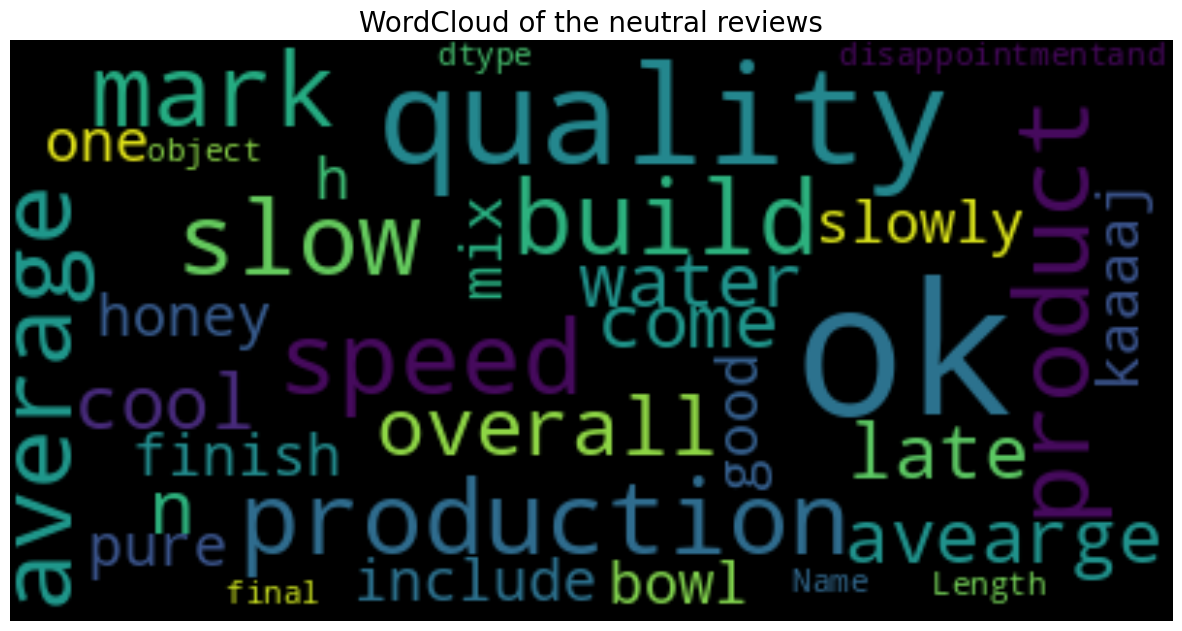

In [38]:
#create word cloud of neutral reviews
from wordcloud import WordCloud
WordCloud_recommended = WordCloud(max_words=500,
                                  random_state=30,
                                  collocations=True).generate(str((df_neutral['final'])))

plt.figure(figsize=(15, 8))
plt.imshow(WordCloud_recommended, interpolation='bilinear')
plt.title('WordCloud of the neutral reviews', fontsize=20)
plt.axis("off")
plt.show()

Common keywords in neutral reviews include: overall, average or ok. Show a neutral attitude towards the product.

# Building models

## Train test split

In [ ]:
df_class = df1.copy()

In [ ]:
df_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205038 entries, 0 to 205051
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   product_name     205038 non-null  object
 1   product_price    205038 non-null  int64 
 2   Rate             205038 non-null  int64 
 3   Review           180376 non-null  object
 4   Summary          205038 non-null  object
 5   Sentiment        205038 non-null  object
 6   Sentiment_num    205038 non-null  int64 
 7   length_of_text   205038 non-null  int64 
 8   text_tokenized   205038 non-null  object
 9   no_stop_word     205038 non-null  object
 10  text_lemmatized  205038 non-null  object
 11  final            205038 non-null  object
dtypes: int64(4), object(8)
memory usage: 28.4+ MB


In [ ]:
x = df_class['final']
y = df_class['Sentiment']

In [ ]:

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(x)

In [ ]:
df_class['Sentiment'].value_counts()

positive    166573
negative     28231
neutral      10234
Name: Sentiment, dtype: int64

- Since the data is not balanced (significantly more positive reviews) it will affect the prediction results.
- There should be a method of dividing the train test set so that the ratio of the number of sentiments is kept.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


stratify: This parameter is used to specify the y label to perform Stratified Sampling, ensuring the proportion of classes is preserved in both train and test sets.

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [ ]:
nb.fit(X_train,y_train)

MultinomialNB()

In [ ]:
prediction_nb = nb.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(confusion_matrix(y_test,prediction_nb))

[[ 3814    47  1785]
 [  295   167  1585]
 [  640   133 32542]]


In [ ]:
print(classification_report(y_test,prediction_nb))

              precision    recall  f1-score   support

    negative       0.80      0.68      0.73      5646
     neutral       0.48      0.08      0.14      2047
    positive       0.91      0.98      0.94     33315

    accuracy                           0.89     41008
   macro avg       0.73      0.58      0.60     41008
weighted avg       0.87      0.89      0.87     41008



## XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
y1=df_class['Sentiment_num']

In [ ]:
# X is the feature matrix, y is the label vector
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, stratify=y, random_state=42)

In [ ]:
prediction_xgb = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)

In [ ]:
prediction_xgb.fit(X_train, y1_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [ ]:
y_pred_xgb=prediction_xgb.predict(X_test)

In [ ]:
print(confusion_matrix(y1_test,y_pred_xgb))

[[ 3758   111  1777]
 [  239   859   949]
 [  378   191 32746]]


In [ ]:
print(classification_report(y1_test,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.86      0.67      0.75      5646
           1       0.74      0.42      0.54      2047
           2       0.92      0.98      0.95     33315

    accuracy                           0.91     41008
   macro avg       0.84      0.69      0.75     41008
weighted avg       0.91      0.91      0.90     41008



## LSTM

In [ ]:
#import some libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
# Split the data into training and test sets
train_data, test_data = train_test_split(df_class, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Text data preprocessing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['final'])
X_train = tokenizer.texts_to_sequences(train_data['final'])
X_test = tokenizer.texts_to_sequences(test_data['final'])

In [ ]:
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size

In [ ]:
max_len = 50  # Maximum length of each string
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
# Label handling
y_train = train_data['Sentiment_num']
y_test = test_data['Sentiment_num']

In [ ]:
# Convert labels to one-hot encoding
num_classes = 3
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [ ]:
# Building the LSTM model
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=max_len))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
5126/5126 [==============================] - 483s 94ms/step - loss: 0.2798 - accuracy: 0.9083 - val_loss: 0.2401 - val_accuracy: 0.9213
Epoch 2/10
5126/5126 [==============================] - 477s 93ms/step - loss: 0.2245 - accuracy: 0.9262 - val_loss: 0.2376 - val_accuracy: 0.9216
Epoch 3/10
5126/5126 [==============================] - 474s 92ms/step - loss: 0.2038 - accuracy: 0.9330 - val_loss: 0.2398 - val_accuracy: 0.9219
Epoch 4/10
5126/5126 [==============================] - 483s 94ms/step - loss: 0.1906 - accuracy: 0.9373 - val_loss: 0.2440 - val_accuracy: 0.9211
Epoch 5/10
5126/5126 [==============================] - 472s 92ms/step - loss: 0.1794 - accuracy: 0.9411 - val_loss: 0.2492 - val_accuracy: 0.9197
Epoch 6/10
5126/5126 [==============================] - 469s 92ms/step - loss: 0.1716 - accuracy: 0.9441 - val_loss: 0.2540 - val_accuracy: 0.9190
Epoch 7/10
5126/5126 [==============================] - 478s 93ms/step - loss: 0.1642 - accuracy: 0.9463 - val_loss: 0

In [ ]:
# Evaluation of accuracy on test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

1282/1282 [==============================] - 20s 16ms/step - loss: 0.2764 - accuracy: 0.9173
Loss: 0.27639949321746826
Accuracy: 0.9172600507736206


1. The results compare the accuracy of 3 models: Naïve Bayes, XGBoost and LSTM in text classification.
- Naïve Bayes: 0.89
- XGBoost: 0.91
- LSTM: 0.92
2. It can be concluded that LSTM is better than Naïve Bayes and XGBoost in text classification.

# Conclusion

1. EDA
- The number of 5-star ratings accounted for the most, 2-star ratings accounted for the least, and 1-star ratings ranked 3rd. That shows that most products satisfy customers. A few of them are not satisfied but have not reacted negatively yet (rate 2 instead of 1 star). The number of 1-star ratings is still high, businesses need to find out which products or industries receive the most 1-star reviews to make adjustments.
- Because the number of 5-star ratings accounted for the most, the number of positive reviews also accounted for the most. Followed by negative reviews and neutral reviews. This further confirms that there are products that disappoint customers. Businesses need to find these products and improve them.
- The length of comments focuses on the range of 0-20 words. In particular, from the distribution chart, it can be seen that long reviews are negative reviews and shorter reviews are neutral or positive. This may explain that when customers give 1 star or negative reviews, sellers often ask students to provide more experiences so they can improve.
2. Word Clouds
- Common keywords in negative reviews include: small, bad, fan, size. These keywords indicate that customers are not satisfied with the cooling devices such as: cooler or fan, they are quite small than expected or of poor quality.
- Popular keywords in positive reviews include: nice, good, air, cooler, excellent, great, amaze. These reviews show that customers have a good experience with the product. The keyword cooler appears in both positive and negative reviews because this is the main product of the business.
- Common keywords in neutral reviews include: overall, average or ok. Show a neutral attitude towards the product.
3. Text classification models comparision
- The results compare the accuracy of 3 models: Naïve Bayes, XGBoost and LSTM in text classification.
  - Naïve Bayes: 0.89
  - XGBoost: 0.91
  - LSTM: 0.92
- It can be concluded that LSTM is better than Naïve Bayes and XGBoost in text classification.